In [ ]:
# === 0) Imports necesarios ===

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings 
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_arch
warnings.filterwarnings("ignore")

In [2]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod.csv", sep=";", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y") #Convertir la columna 'date' a formato datetime
df = df.set_index("date") #Establecer la columna 'date' como índice 
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y

In [3]:
# === 2) Método de evaluación (División del dataset 80/20) ===

division_idx = int(len(y) * 0.80) # Índice de división para el 80%
entreno_idx = y.index[:division_idx] # Índices de entrenamiento
test_idx  = y.index[division_idx:] # Índices de prueba

In [4]:
# === 3) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0:
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()

In [5]:
# === 4) División de los datos de entrenamiento y prueba ===

datos_entreno = y_masked.loc[entreno_idx] # Datos de entrenamiento
datos_prueba = y_masked.loc[test_idx] # Datos de prueba


In [6]:
# === 5) Optimización de las variables P,D,Q y p,d,q ===

p = d = q = range(0, 2) # Valores posibles para p, d, q del 0 al 1   
P = D = Q = range(0, 2) # Valores posibles para p, d, q del 0 al 1
m = 12 

resultados=[]

# Combinaciones de parámetros SARIMA
# Se generan todas las combinaciones posibles de (p,d,q,P,D,Q) para SARIMA
# Se usa itertools.product para generar el producto cartesiano de los rangos definidos
for comb in itertools.product(p, d, q, P, D, Q):
    try:
        model = SARIMAX(y, order=(comb[0], comb[1], comb[2]),
                           seasonal_order=(comb[3], comb[4], comb[5], m),
                           enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        resultados.append((res.aic, comb))
    except:
        continue


best_aic, best_tuple = min(resultados, key=lambda t: t[0]) # Obtener la combinación con el AIC más bajo
p_best, d_best, q_best, P_best, D_best, Q_best = best_tuple # Desempaquetar la mejor combinación de parámetros

resultados.sort(key=lambda x: x[0]) # Ordenar resultados por AIC
print("Mejores combinaciones (AIC bajo):") # Imprimir las 5 mejores combinaciones

# Mostrar las 5 mejores combinaciones de parámetros con sus respectivos AIC
for aic, comb in resultados[:5]:
    print(f"AIC={aic:.1f} → (p,d,q,P,D,Q)={comb}")
print(f"\nMejor combinación encontrada: AIC={best_aic:.1f} → (p,d,q,P,D,Q)=({p_best},{d_best},{q_best},{P_best},{D_best},{Q_best})")

Mejores combinaciones (AIC bajo):
AIC=1708.9 → (p,d,q,P,D,Q)=(0, 1, 1, 1, 1, 1)
AIC=1709.2 → (p,d,q,P,D,Q)=(0, 1, 1, 0, 1, 1)
AIC=1710.1 → (p,d,q,P,D,Q)=(1, 1, 1, 0, 1, 1)
AIC=1722.5 → (p,d,q,P,D,Q)=(1, 1, 1, 1, 1, 1)
AIC=1724.9 → (p,d,q,P,D,Q)=(1, 0, 1, 0, 1, 1)

Mejor combinación encontrada: AIC=1708.9 → (p,d,q,P,D,Q)=(0,1,1,1,1,1)


In [7]:
# === 6) Entrenamiento del modelo ===

# Modelo con los mejores parámetros encontrados automáticamente
modelo = SARIMAX(datos_entreno, order=(p_best, d_best, q_best), seasonal_order=(P_best, D_best, Q_best, m),
              enforce_stationarity=True, enforce_invertibility=True)

modelo_entrenado = modelo.fit() # Entrenamiento del modelo

In [8]:
# === 7) Predicciones del modelo ===

predicciones_modelo = modelo_entrenado.get_forecast(steps=len(datos_prueba)) # Predicciones futuras 
predicciones = predicciones_modelo.predicted_mean # Valores predichos
pred_intervalo_confianza = predicciones_modelo.conf_int() # Intervalo de confianza de las predicciones

#Preparación de los datos para la evaluación del modelo
eval_df = pd.concat(
    [datos_prueba.rename("y_true").astype(float), predicciones.rename("y_pred").astype(float)],
    axis=1
).dropna()

# Asignación de los valores verdaderos y predichos
y_verd = eval_df["y_true"].values
y_pred = eval_df["y_pred"].values


In [9]:
# === 8) Cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }

# Cálculo y presentación de las métricas
metrics = metricas(y_verd, y_pred, eps_mape=1.0)

# Impresión de las métricas
for k, v in metrics.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

R2: 0.52
RMSLE: 0.53
RMSE: 1,897.47
MAE: 1,666.29
MAPE_safe(%): 57.77%
SMAPE(%): 37.18%
WAPE(%): 31.01%


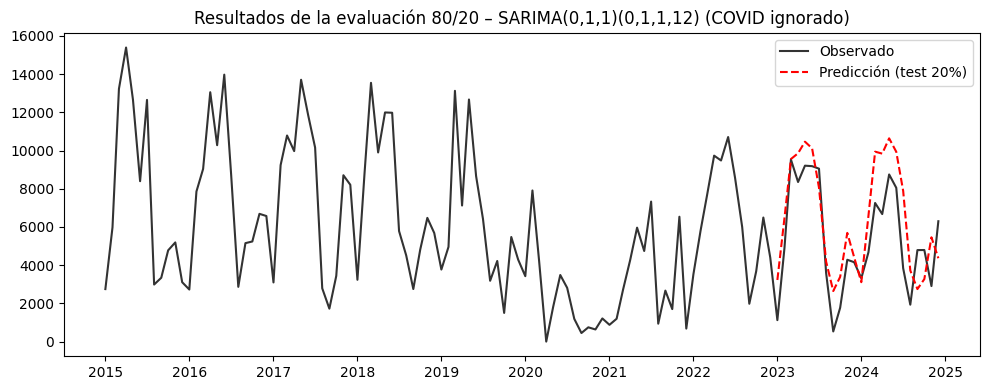

In [10]:
# === 8) Gráfico evaluación entrenamiento  ===

# Gráfico evaluación
plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones.index, predicciones, "--", label="Predicción (test 20%)", color="red")
plt.title("Resultados de la evaluación 80/20 – SARIMA(0,1,1)(0,1,1,12) (COVID ignorado)")
plt.legend(); plt.tight_layout(); plt.show()

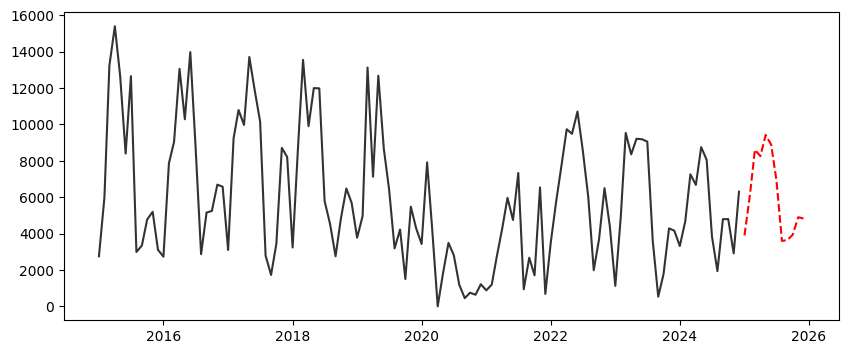

In [11]:
# === 8) Gráfico predicción  ===

# Predicciones futuras a 12 meses
pred_fut = res.get_forecast(steps=12) # Predicciones a 12 meses
predicciones_futuras = pred_fut.predicted_mean # Valores predichos

# Graficar la predicción
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones_futuras.index, predicciones_futuras, "--", label="Forecast +12m", color="red")

In [ ]:
# === 9) Función completa de entrenamiento y  con variantes para encontrar el mejor modelo ===

# Definición de la función para evaluar métricas
def eval_metricas(y_verd, y_pred):
    df = pd.concat([y_verd.rename("y"), y_pred.rename("yhat")], axis=1) # Crear DataFrame con valores reales y predichos
    yv, yp = df["y"].values, df["yhat"].values
    r2 = r2_score(yv, yp)
    rmses=rmse(yv, yp)
    rmsles=rmsle(yv, yp)
    maes=mae(yv, yp)
    mapes=mape_safe(yv, yp)
    wapes = wape(yv, yp, eps=1e-8)
    smapes = smape(yv, yp, eps=1e-8)
    print({"R2": float(r2), "RMSE": float(rmses), "RMSLE": float(rmsles), "mae": float(maes), "mapes": float(mapes),"SMAPE(%)": float(smapes), "WAPE(%)": float(wapes)})
    return {"R2": float(r2), "WAPE(%)": float(wapes), "SMAPE(%)": float(smapes)}

# def entreno_variantes(y, order=(p_best,q_best,d_best), seas=(P_best,Q_best,D_best,m), split_ratio=0.8, horizon=12):
def entreno_variantes(y, order=(0,1,1), seas=(0,1,1,12), split_ratio=0.8, horizon=12):
    
    s = int(len(y)*split_ratio); train, test = y.iloc[:s], y.iloc[s:] # Dividir los datos en entrenamiento y prueba

    # variantes
    variants = {}

    # A) base (sin drift)
    resA = SARIMAX(train, order=order, seasonal_order=seas, trend="n", # sin drift
                   enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
    predA = resA.get_forecast(steps=len(test)).predicted_mean
    variants["base"] = eval_metricas(test, predA) # evaluación base

    # B) drift
    resB = SARIMAX(train, order=order, seasonal_order=seas, trend="c", # drift
                   enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
    predB = resB.get_forecast(steps=len(test)).predicted_mean
    variants["drift"] = eval_metricas(test, predB) # evaluación drift

    # C) log1p + bias fix
    tr_log = np.log1p(np.maximum(train, 0)) 
    resC = SARIMAX(tr_log, order=order, seasonal_order=seas, trend="c", # log1p + drift
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    prC = resC.get_forecast(steps=len(test))
    mu, var = prC.predicted_mean, prC.var_pred_mean # Obtener media y varianza
    predC = pd.Series(np.exp(mu + 0.5*var) - 1.0, index=mu.index) # Inversa de log1p
    variants["log1p_biasfix"] = eval_metricas(test, predC) # evaluación log1p + bias fix
    
    # D) Rolling refit 1-step 
    preds_roll, idx = [], [] # listas para predicciones e índices
    #
    for t in range(s, len(y)):
        ytr = y.iloc[:t]  
        res = SARIMAX(ytr, order=order, seasonal_order=seas, trend="c",
                    enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
        preds_roll.append(res.get_forecast(steps=1).predicted_mean.iloc[0])
        idx.append(y.index[t])

    pred_roll = pd.Series(preds_roll, index=idx)
    variants["rolling_refit_1step"] = eval_metricas(y.iloc[s:], pred_roll) # evaluación rolling refit 1-step

    # Presentación de resultados y selección del ganador
    df_result = (pd.DataFrame([{"Variante": k, **v} for k,v in variants.items()])
                   .sort_values("WAPE(%)").reset_index(drop=True))
    
    winner = df_result.loc[0, "Variante"]  # la variante con menor WAPE
    # Condicional para mostrar la predicción final según el ganador
    if winner == "base":
        resa = SARIMAX(y, order=order, seasonal_order=seas, trend="n",
                       enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
        fc = resa.get_forecast(steps=horizon).predicted_mean
    elif winner == "drift":
        resa = SARIMAX(y, order=order, seasonal_order=seas, trend="c",
                       enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
        fc = resa.get_forecast(steps=horizon).predicted_mean
    elif winner == "log1p_biasfix":
        ylog = np.log1p(np.maximum(y, 0))
        resa = SARIMAX(ylog, order=order, seasonal_order=seas, trend="c",
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pr = resa.get_forecast(steps=horizon)
        mu, var = pr.predicted_mean, pr.var_pred_mean
        fc = pd.Series(np.exp(mu + 0.5*var) - 1.0, index=mu.index)
    else:
          # rolling_refit_1step
        preds_roll, idx = [], [] # listas para predicciones e índices
        for t in range(s, len(y)):
            ytr = y.iloc[:t]
            res = SARIMAX(ytr, order=order, seasonal_order=seas, trend="c",
                          enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
            preds_roll.append(res.get_forecast(steps=1).predicted_mean.iloc[0])
            idx.append(y.index[t])
        fc = pd.Series(preds_roll, index=idx)

    return df_result, winner, fc

# Ejecución de la función con variantes

# df_result, winner, prediccion12 = entreno_variantes(
#     y_masked, order=(0,1,1), seas=(0,1,1,12),
#     split_ratio=0.80, horizon=12
# )

# # Ejecución de la función con variantes y mejores parámetros encontrados automáticamente
df_result, winner, prediccion12 = entreno_variantes(
    y_masked, order=(p_best,d_best,q_best), seas=(P_best,D_best,Q_best,m),
    split_ratio=0.80, horizon=12
)

# Presentación de resultados y predicciones
print(df_result)
print("Predicción 12 mes:\n", prediccion12)


{'R2': 0.4954122830168941, 'RMSE': 1944.08124763626, 'RMSLE': 0.5307338277715508, 'mae': 1720.265621094504, 'mapes': 58.30298693874464, 'SMAPE(%)': 37.25032364577686, 'WAPE(%)': 32.01933807934427}
{'R2': 0.6314092771253805, 'RMSE': 1661.5685909259662, 'RMSLE': 0.5080377556299395, 'mae': 1417.6823356012073, 'mapes': 44.897699176754195, 'SMAPE(%)': 35.6119107183076, 'WAPE(%)': 26.38734939308292}
{'R2': 0.090390384936886, 'RMSE': 2610.1988569109203, 'RMSLE': 0.6163164200388159, 'mae': 2183.308202418299, 'mapes': 71.81108412998913, 'SMAPE(%)': 44.42471223798049, 'WAPE(%)': 40.63795881717297}
{'R2': 0.5969880545922354, 'RMSE': 1737.4208677233053, 'RMSLE': 0.637323887952128, 'mae': 1352.4621598019357, 'mapes': 42.49044207824341, 'SMAPE(%)': 38.24044402811852, 'WAPE(%)': 25.173404969091884}
              Variante        R2    WAPE(%)   SMAPE(%)
0  rolling_refit_1step  0.596988  25.173405  38.240444
1                drift  0.631409  26.387349  35.611911
2                 base  0.495412  32.019

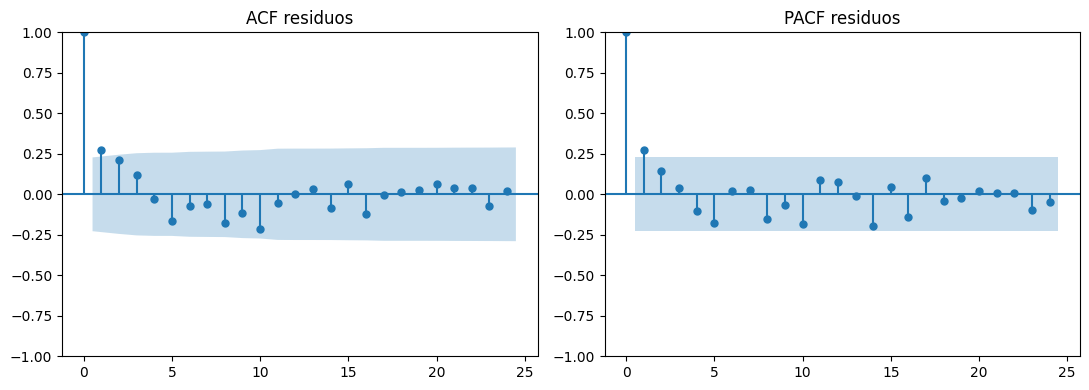

      lb_stat  lb_pvalue
12  21.779630   0.040065
24  25.745664   0.366195


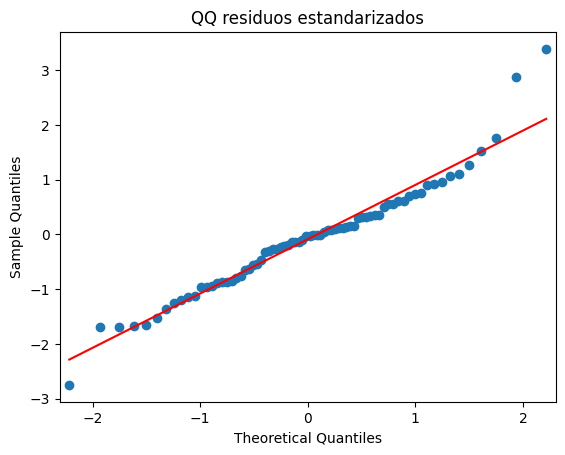

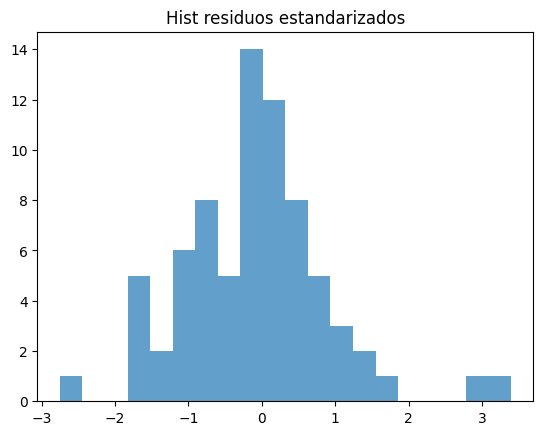

Durbin–Watson: 1.4237745847011107
ARCH test: (np.float64(18.47261394753415), np.float64(0.04749573599441719), 2.150460687751879, 0.03603704267183149)


In [ ]:
# === 10) Análisis de residuos del modelo óptimo ===
order = (p_best,d_best,q_best) # Mejores parámetros p,d,q
seasonal_order = (P_best,D_best,Q_best,m) # Mejores parámetros P,D,Q,m

# order = (0,1,1)
# seasonal_order = (0,1,1,12)

#   Modelo óptimo con drift
modelo_optimo = SARIMAX(datos_entreno, order=order, seasonal_order=seasonal_order,
              trend="c", enforce_stationarity=True, enforce_invertibility=True)

modelo_optimo_entrenado = modelo_optimo.fit(disp=False)

 #  Predicciones del modelo óptimo
predicciones_futuras_optimas = modelo_optimo_entrenado.get_forecast(steps=len(datos_prueba)) # Predicciones futuras
valores_predicciones_optimas = predicciones_futuras_optimas.predicted_mean #
intervalo_confianza_optimo = predicciones_futuras_optimas.conf_int()   

# Análisis de residuos
resid = pd.Series(modelo_optimo_entrenado.resid, index=datos_entreno.index).dropna()

# Gráficos ACF y PACF de los residuos
fig, ax = plt.subplots(1, 2, figsize=(11,4))
plot_acf(resid, lags=24, ax=ax[0])
plot_pacf(resid, lags=24, ax=ax[1])
ax[0].set_title("ACF residuos")
ax[1].set_title("PACF residuos")
plt.tight_layout()
plt.show()




# Distribución de los residuos
resid_std = resid / resid.std(ddof=1)
# QQ y hist
sm.qqplot(resid_std, line="s"); plt.title("QQ residuos estandarizados"); plt.show()
plt.figure(); plt.hist(resid_std, bins=20, alpha=0.7); plt.title("Hist residuos estandarizados"); plt.show()

# Prueba de Ljung-Box para autocorrelación

print(sm.stats.acorr_ljungbox(resid, lags=[12,24], return_df=True))
# Durbin–Watson y ARCH test
print("Durbin–Watson:", durbin_watson(resid))
print("ARCH test:", het_arch(resid))

Cobertura del intervalo 95% en test: 100.0%


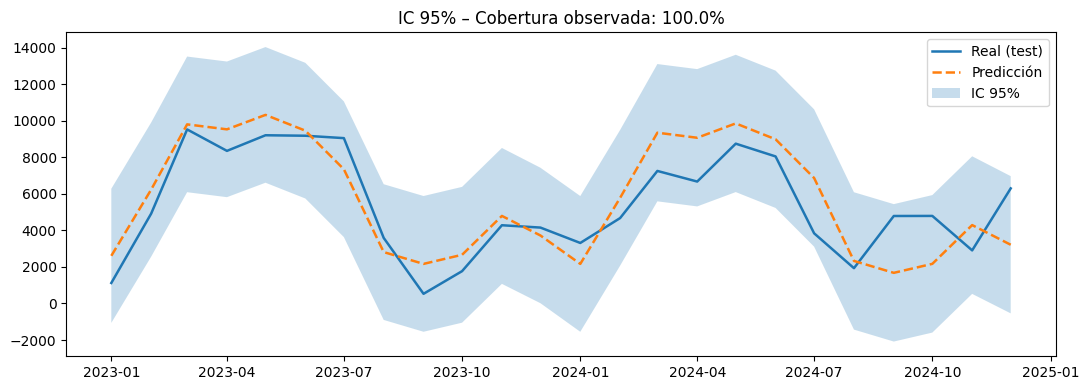

In [14]:
# === 11) Cobertura del intervalo de confianza al 95% ===
df_cov = pd.concat(
    [datos_prueba.rename("y"), valores_predicciones_optimas.rename("yhat"), intervalo_confianza_optimo.iloc[:,0].rename("lo"), intervalo_confianza_optimo.iloc[:,1].rename("hi")],
    axis=1
).dropna()
coverage = float(((df_cov["y"] >= df_cov["lo"]) & (df_cov["y"] <= df_cov["hi"])).mean() * 100)

print(f"Cobertura del intervalo 95% en test: {coverage:.1f}%")

plt.figure(figsize=(11,4))
plt.plot(df_cov.index, df_cov["y"], label="Real (test)", linewidth=1.8)
plt.plot(df_cov.index, df_cov["yhat"], "--", label="Predicción", linewidth=1.8)
plt.fill_between(df_cov.index, df_cov["lo"], df_cov["hi"], alpha=0.25, label="IC 95%")
plt.title(f"IC 95% – Cobertura observada: {coverage:.1f}%")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# === 12) Cálculo de métricas de evaluación del modelo óptimo ===
eval_df = pd.concat(
    [datos_prueba.rename("y_true").astype(float), valores_predicciones_optimas.rename("y_pred").astype(float)],
    axis=1
).dropna()

# Asignación de los valores verdaderos y predichos
y_verd_opt = eval_df["y_true"].values
y_pred_opt = eval_df["y_pred"].values

# Cálculo y presentación de las métricas
metrics_opt = metricas(y_verd_opt, y_pred_opt, eps_mape=1.0)

# Impresión de las métricas
for k, v in metrics_opt.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

R2: 0.63
RMSLE: 0.51
RMSE: 1,661.57
MAE: 1,417.68
MAPE_safe(%): 44.90%
SMAPE(%): 35.61%
WAPE(%): 26.39%


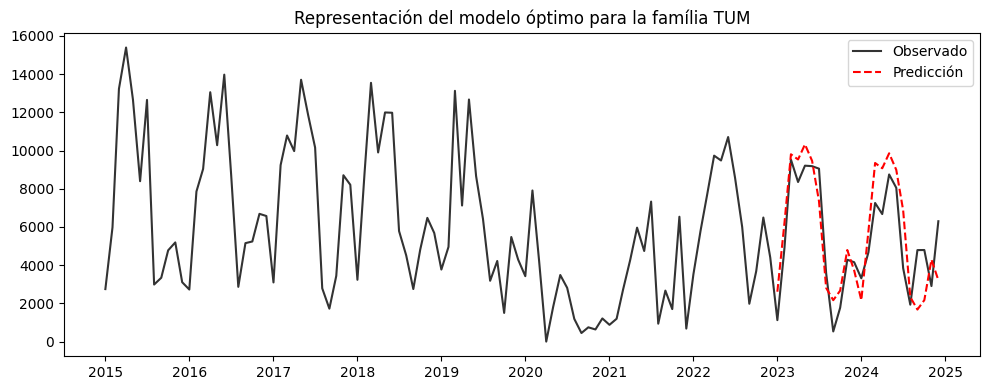

In [ ]:
# === 13) Gráfico evaluación modelo óptimo ===

# Gráfico evaluación modelo óptimo
plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(valores_predicciones_optimas.index, valores_predicciones_optimas, "--", label="Predicción", color="red")
plt.title("Representación del modelo óptimo para la família TUM")
plt.legend(); plt.tight_layout(); plt.show()

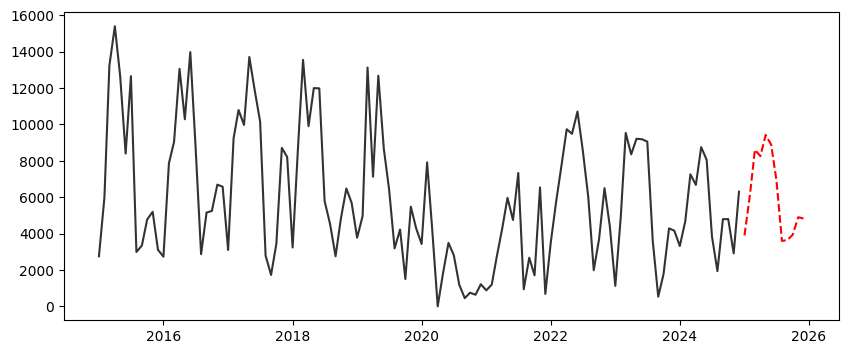

In [ ]:
# === 14) Predicciones futuras a 12 meses ===

# Predicciones futuras a 12 meses
pred_fut = res.get_forecast(steps=12) # Predicciones a 12 meses
predicciones_futuras = pred_fut.predicted_mean # Valores predichos

# Graficar la predicción
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones_futuras.index, predicciones_futuras, "--", label="Forecast +12m", color="red")